# Full detector response

The detector response provides us with the the following information:
- The effective area at given energy for given direction. This allows us to convert from counts to physical quantities like flux
- The expected distribution of measured energy and other reconstructed quantities. This allows us to account for all sorts of detector effects when we do our analysis.

This tutorial will show you how to handle detector response and extrat useful information from it:

## Opening a full detector response

The response of the instrument in encoded in a series of matrices cointained in a file. you can open the file like this:

<div class="alert alert-info">
DEVELOPERS: I'm using HDF5 for now, but I think all these features can be implemented with FITS.
</div>

In [1]:
response_path = "/Users/israel/cosi/scratch/rsp/test_cosi_full_detector_response_v1.h5"

In [2]:
from cosipy.response import FullDetectorResponse

response = FullDetectorResponse.open(response_path)

print(response.filename)

response.close()

/Users/israel/cosi/scratch/rsp/test_cosi_full_detector_response_v1.h5


Or if you don't want to worry about closing the file, use a context manager statement:

In [3]:
with FullDetectorResponse.open(response_path) as response:

    print(response.describe())

FILENAME: '/Users/israel/work/cosi/scratch/rsp/test_cosi_full_detector_response_v1.h5'
NPIX: 48
NSIDE: 2
SCHEME: 'RING'
AXES:
  Ei:
    DESCRIPTION: 'Initial simulated energy'
    TYPE: 'log'
    UNIT: 'keV'
    NBINS: 10
    EDGES: [150.0, 220.0, 325.0, 480.0, 520.0, 765.0, 1120.0, 1650.0, 2350.0, 3450.0, 5000.0]
  Em:
    DESCRIPTION: 'Measured energy'
    TYPE: 'log'
    UNIT: 'keV'
    NBINS: 10
    EDGES: [150.0, 220.0, 325.0, 480.0, 520.0, 765.0, 1120.0, 1650.0, 2350.0, 3450.0, 5000.0]
  Phi:
    DESCRIPTION: 'Compton angle'
    TYPE: 'linear'
    UNIT: 'deg'
    NBINS: 30
    EDGES: [0.0, 6.0, 12.0, 18.0, 24.0, 30.0, 36.0, 42.0, 48.0, 54.0, 60.0, 66.0, 72.0, 78.0, 84.0, 90.0, 96.0, 102.0, 108.0, 114.0, 120.0, 126.0, 132.0, 138.0, 144.0, 150.0, 156.0, 162.0, 168.0, 174.0, 180.0]
  PsiChi:
    DESCRIPTION: 'Location in the Compton Data Space'
    TYPE: 'healpix'
    NPIX: 48
    NSIDE: 2
    SCHEME: 'RING'
  SigmaTau:
    DESCRIPTION: 'Electron recoil angle'
    TYPE: 'healpix'
  

Although opening a detector response does not load the matrices, it loads all the header information above. This allows us to pass it around for various analysis at a very low cost.

## Detector response matrix

The full --i.e. all-sky-- detector response is encoded in a HEALPix grid. For each pixel there is a multidimensional matrix describing the response of the instrument for that particular direction in the spacefraft coordinates. For this response has the following grid:

In [4]:
import numpy as np
import astropy.units as u

with FullDetectorResponse.open(response_path) as response:
    
    print(f"NSIDE = {response.nside}")
    print(f"SCHEME = {response.scheme}")
    print(f"NPIX = {response.npix}")
    print(f"Pixel size = {np.sqrt(response.pixarea()).to(u.deg):.2f}")

NSIDE = 2
SCHEME = RING
NPIX = 48
Pixel size = 29.32 deg


To retrieve the detector response matrix for a given pixel simply use the `[]` operator

In [5]:
with FullDetectorResponse.open(response_path) as response:
    
    drm = response[0]

Or better, get the interpolated matrix for a given direction. In this case, for the on-axis response:

In [6]:
from cosipy.coordinates import SpacecraftFrame
from astropy.coordinates import SkyCoord

with FullDetectorResponse.open(response_path) as response:
    
    drm = response.get_interp_response(SkyCoord(lon = 0*u.deg, lat = 0*u.deg, frame = SpacecraftFrame()))

The matrix has multiple dimensions, including real photon initial energy, the measured energy, the Compton data space, and possibly other:

In [7]:
drm.axes.labels

array(['Ei', 'Em', 'Phi', 'PsiChi', 'SigmaTau', 'Dist'], dtype='<U8')

However, one of the most common operation is to get the effective area and the energy dispersion matrix. This is encoded in a SpectralResponse, which is just the projection of the full matrix into the initial and measured energy axes:

In [8]:
spec_drm = drm.get_spectral_response()

In [9]:
spec_drm.axes.labels

array(['Ei', 'Em'], dtype='<U2')

You can further project it into the initial energy to get the effective area:

Text(0, 0.5, 'Aeff [cm2]')

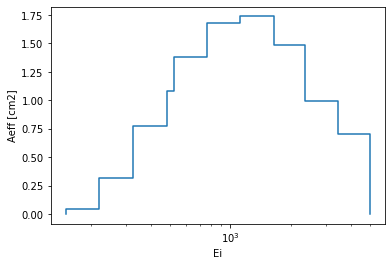

In [11]:
ax,plot = spec_drm.get_effective_area().plot(errorbars = None);

ax.set_ylabel(f'Aeff [{spec_drm.unit}]')

Get the interpolated effective area

In [13]:
spec_drm.get_effective_area(511*u.keV)

<Quantity 1.10861314 cm2>

Or the energy dispersion matrix

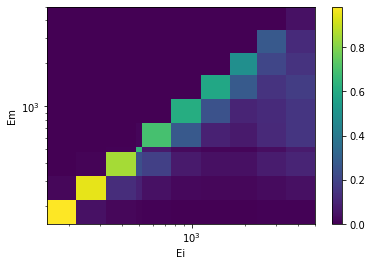

In [14]:
spec_drm.get_dispersion_matrix().plot();

## Point source response

One we have the response, usually the next step if to get the expected excess for a specific source. We first mock the path of a source across the field of view of the instrument. This is encoded in another HEALPix map containing the (weighted) time a source spent on each pixel:

In [15]:
from mhealpy import HealpixMap

t_tot = 12*u.hr
t_nsamples = 1000
t = np.linspace(0,t_tot,t_nsamples)

theta = t*(180*u.deg/u.day)
phi = t*(180*u.deg/u.hour)

path = SkyCoord(lon = phi, lat = 90*u.deg - theta, frame = SpacecraftFrame())

with FullDetectorResponse.open(response_path) as response:
    
    exposure_map = HealpixMap(base = response, 
                              unit = u.s, 
                              coordsys = SpacecraftFrame())

    for coord in path:
        
        # This takes care of the interpolation without having to load the pixel DRM multiple times from file
        pixels, weights = exposure_map.get_interp_weights(coord)
        
        for p,w in zip(pixels, weights):
            exposure_map[p] += w*t_tot/t_nsamples
    

<div class="alert alert-info">
DEVELOPERS: The Orientation class should produce this map using spacecraft data
</div>

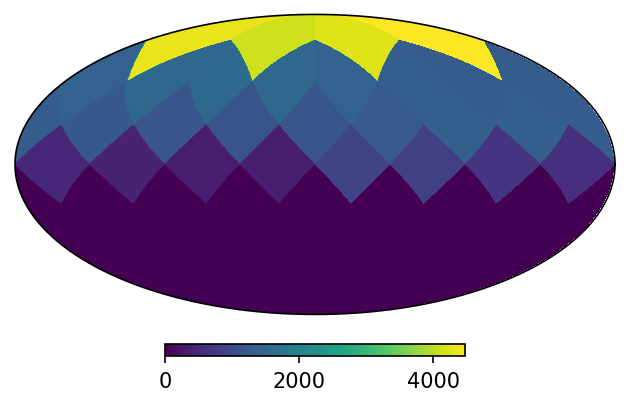

In [16]:
# We need to specify a quaternion attitude because plot() converts the maps to ICRS. [0,0,0,1] is the identity matrix
exposure_map.plot(coord = SpacecraftFrame(attitude = [0,0,0,1]));

We can now convolve the exposure maps with the full detector response, and get a PointSourceResponse

In [17]:
with FullDetectorResponse.open(response_path) as response:
    psr = response.get_point_source_response(exposure_map)

Note that a PointSourceResponse only depends on the path of the source, not on the spectrum of the source. It has units of area*time

In [18]:
psr.unit

Unit("cm2 s")

Finally, we convolve a spectrum to get the spected excess for each _measured_ energy bin:

In [19]:
from gammapy.modeling.models import PowerLawSpectralModel

spectrum = PowerLawSpectralModel(index = 2.2,
                                 amplitude = 10**-3 / u.cm / u.cm / u.s / u.keV,
                                 reference = 100 * u.keV)
    
expectation = psr.get_expectation(spectrum)

<div class="alert alert-info">
DEVELOPERS: Using gammapy here seemed convenient. Let's discuss it
</div>

Text(0, 0.5, 'Expected counts')

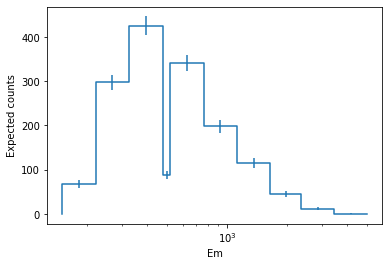

In [20]:
ax, plot = expectation.project('Em').plot()

ax.set_ylabel('Expected counts')

Try changing the spectrum and se how the expected excess changes.

Text(0, 0.5, 'Expected counts')

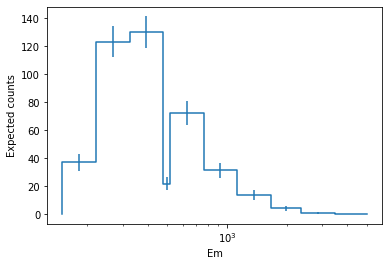

In [21]:
spectrum = PowerLawSpectralModel(index = 3,
                                 amplitude = 10**-3 / u.cm / u.cm / u.s / u.keV,
                                 reference = 100 * u.keV)
    
expectation = psr.get_expectation(spectrum)

ax, plot = expectation.project('Em').plot()

ax.set_ylabel('Expected counts')